---
title: Unsupervised methods - Dimensionality reduction
teaching: 30
exercises: 30
---

:::::::::::::::::::::::::::::::::::::: questions 

- How do we apply machine learning techniques to data with higher dimensions?

::::::::::::::::::::::::::::::::::::::::::::::::

::::::::::::::::::::::::::::::::::::: objectives

- Recall that most data is inherently multidimensional.
- Understand that reducing the number of dimensions can simplify modelling and allow classifications to be performed.
- Apply Principle Component Analysis (PCA) and t-distributed Stochastic Neighbor Embedding (t-SNE) to reduce the dimensions of data.
- Evaluate the relative peformance of PCA and t-SNE in reducing data dimensionality.

::::::::::::::::::::::::::::::::::::::::::::::::

# Dimensionality reduction

As seen in the last episode, general clustering algorithms work well with low-dimensional data. In this episode we see how higher-dimensional data, such as images of handwritten text or numbers, can be processed with dimensionality reduction techniques to make the datasets more accessible for other modelling techniques. The dataset we will be using is the Scikit-Learn subset of the Modified National Institute of Standards and Technology (MNIST) dataset.

![MNIST example illustrating all the classes in the dataset](https://raw.githubusercontent.com/UW-Madison-DataScience/machine-learning-novice-sklearn-v2/main/episodes/fig/MnistExamples.png)


The MNIST dataset contains 70,000 images of handwritten numbers, and are labelled from 0-9 with the number that each image contains. Each image is a greyscale and 28x28 pixels in size for a total of 784 pixels per image. Each pixel can take a value between 0-255 (8bits). When dealing with a series of images in machine learning we consider each pixel to be a feature that varies according to each of the sample images. Our previous penguin dataset only had no more than 7 features to train with, however even a small 28x28 MNIST image has as much as 784 features (pixels) to work with.

![MNIST example of a single image](https://raw.githubusercontent.com/UW-Madison-DataScience/machine-learning-novice-sklearn-v2/main/episodes/fig/mnist_30000-letter.png)

To make this episode a bit less computationally intensive, the Scikit-Learn example that we will work with is a smaller sample of 1797 images. Each image is 8x8 in size for a total of 64 pixels per image, resulting in 64 features for us to work with. The pixels can take a value between 0-15 (4bits). Let's retrieve and inspect the Scikit-Learn dataset with the following code:

In [1]:
# Let's define these here to avoid repetitive code
import numpy as np
import matplotlib.pyplot as plt

def plots_labels(data, labels):
    """
    Visualizes data points with associated labels in a 2D scatter plot.

    Parameters:
    data (ndarray): A 2D NumPy array with shape (n_samples, 2), representing the data points.
    labels (ndarray or list): A 1D array or list of labels corresponding to the data points.

    Returns:
    None: Displays the scatter plot with labels as colors.
    """
    # Extract the x and y coordinates from the data
    tx = data[:, 0]
    ty = data[:, 1]
    
    # Create a figure with a specified size
    fig = plt.figure(1, figsize=(4, 4))
    
    # Scatter plot the data points, coloring them by their labels
    plt.scatter(tx, ty, edgecolor='k', c=labels)
    
    # Display the plot
    plt.show()

def plot_clusters(data, clusters, Kmean):
    """
    Visualizes clustered data points with centroids marked.

    Parameters:
    data (ndarray): A 2D NumPy array with shape (n_samples, 2), representing the data points.
    clusters (ndarray or list): A 1D array or list of cluster assignments for each data point.
    Kmean (KMeans object): The fitted KMeans object containing cluster centers.

    Returns:
    None: Displays the scatter plot with clusters as colors and centroids marked with red crosses.
    """
    # Extract the x and y coordinates from the data
    tx = data[:, 0]
    ty = data[:, 1]
    
    # Create a figure with a specified size
    fig = plt.figure(1, figsize=(4, 4))
    
    # Scatter plot the data points, coloring them by their cluster assignment
    # plt.scatter(tx, ty, s=5, linewidth=0, c=clusters)
    plt.scatter(tx, ty, c=clusters, cmap="nipy_spectral", edgecolor='k')

    # Loop through cluster centers and mark them with a red 'x'
    for cluster_x, cluster_y in Kmean.cluster_centers_:
        plt.scatter(cluster_x, cluster_y, s=100, c='r', marker='x')
    
    # Display the plot
    plt.show()

def plot_clusters_labels(data, labels):
    """
    Visualizes data points with associated labels using a color map and displays a legend.

    Parameters:
    data (ndarray): A 2D NumPy array with shape (n_samples, 2), representing the data points.
    labels (ndarray or list): A 1D array or list of labels corresponding to the data points.

    Returns:
    None: Displays the scatter plot with labels as colors and a color bar for the label legend.
    """
    # Extract the x and y coordinates from the data
    tx = data[:, 0]
    ty = data[:, 1]

    # Create a figure with a specified size
    fig = plt.figure(1, figsize=(5, 4))
    
    # Scatter plot the data points, coloring them by their labels and using a colormap
    plt.scatter(tx, ty, c=labels, cmap="nipy_spectral", 
                edgecolor='k', label=labels)
    
    # Add a color bar to show the label legend
    plt.colorbar(boundaries=np.arange(11) - 0.5).set_ticks(np.arange(10))
    
    # Display the plot
    plt.show()

Next lets load in the digits dataset,

In [2]:
from sklearn import datasets

# load in dataset as a Pandas Dataframe, return X and Y
features, labels = datasets.load_digits(return_X_y=True, as_frame=True)

print(features.shape, labels.shape)
print(labels)
features.head()

(1797, 64) (1797,)
0       0
1       1
2       2
3       3
4       4
       ..
1792    9
1793    0
1794    8
1795    9
1796    8
Name: target, Length: 1797, dtype: int64


,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_6,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0


## Preview data
Each image is 8x8 pixels. We can revert the current "flattened" (aka vectorized) form by using reshape. The -1 tells NumPy to infer the appropriate number of rows automatically. NumPy does this by dividing the total number of elements in the original 1D array (image_1D.size) by 8 (the specified number of columns).

pixel_0_0     0.0
pixel_0_1     0.0
pixel_0_2     5.0
pixel_0_3    13.0
pixel_0_4     9.0
             ... 
pixel_7_3    13.0
pixel_7_4    10.0
pixel_7_5     0.0
pixel_7_6     0.0
pixel_7_7     0.0
Name: 0, Length: 64, dtype: float64


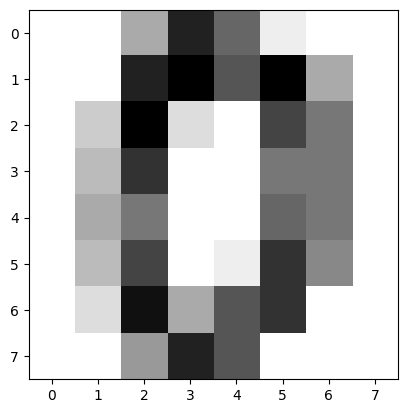

In [3]:
print(features.iloc[0])
image_1D = features.iloc[0]
image_2D = np.array(image_1D).reshape(-1,8)

plt.imshow(image_2D,cmap="gray_r")

## Our goal: using dimensionality-reduction to help with machine learning

As humans we are pretty good at object and pattern recognition. We can look at the images above, inspect the intensity and position pixels relative to other pixels, and pretty quickly make an accurate guess at what the image shows. As humans we spends much of our younger lives learning these spatial relations, and so it stands to reason that computers can also extract these relations. Let's see if it is possible to use unsupervised clustering techniques to pull out relations in our MNIST dataset of number images.


::::::::::::::::::::::::::::::::::::: challenge


## Exercise: Try to visually inspect the dataset and features for correlations
As we did for previous datasets, lets visually inspect relationships between our features/pixels. Try and investigate the following pixels for relations (written "row_column"): 0_4, 1_4, 2_4, and 3_4.

## Solution

pixel_0_0     0.0
pixel_0_1     0.0
pixel_0_2     5.0
pixel_0_3    13.0
pixel_0_4     9.0
             ... 
pixel_7_3    13.0
pixel_7_4    10.0
pixel_7_5     0.0
pixel_7_6     0.0
pixel_7_7     0.0
Name: 0, Length: 64, dtype: float64


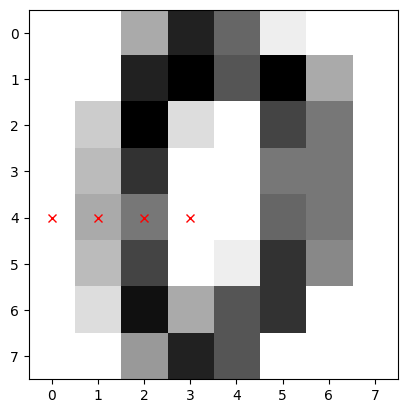

In [4]:
print(features.iloc[0])
image_1D = features.iloc[0]
image_2D = np.array(image_1D).reshape(-1,8)

plt.imshow(image_2D,cmap="gray_r")
# these points are the pixels we will investigate
# pixels 0,1,2,3 of row 4 of the image
plt.plot([0,1,2,3],[4,4,4,4],"rx")
plt.show()

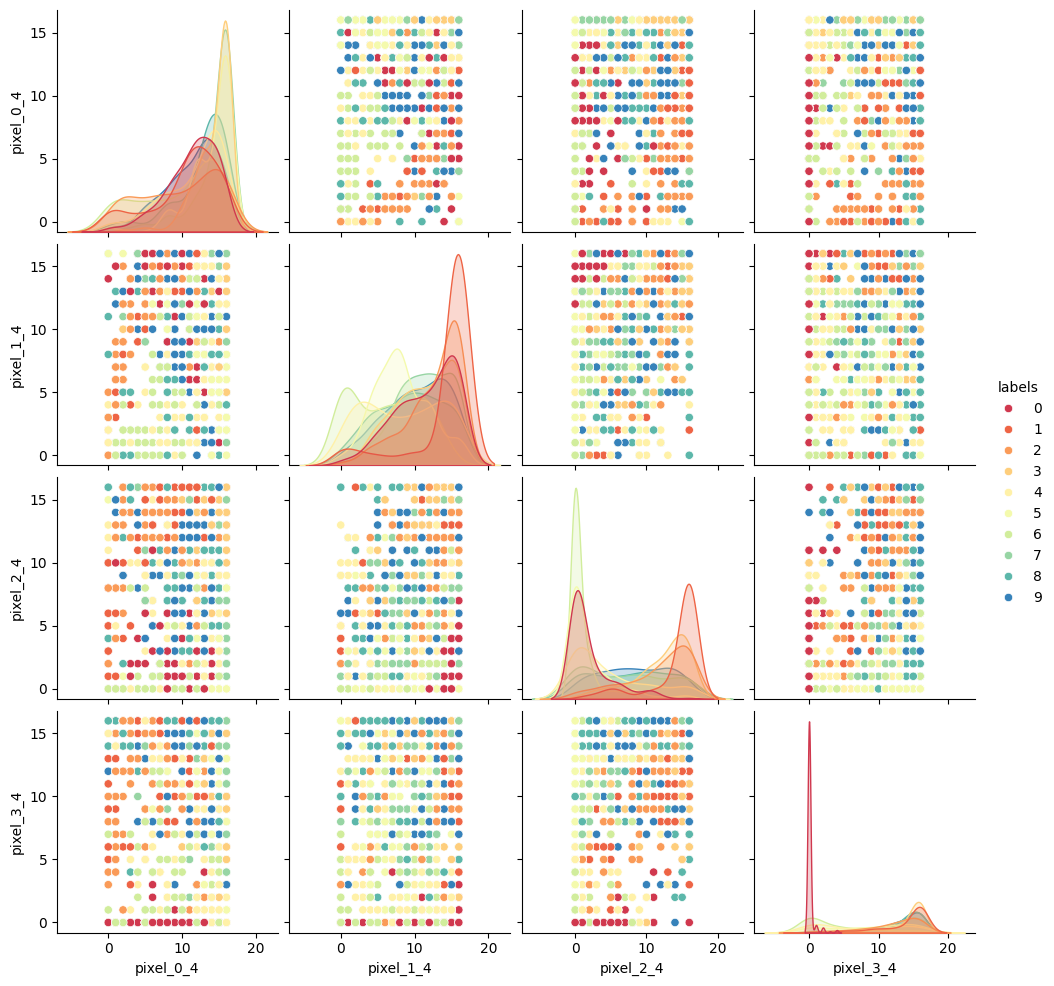

In [5]:
import seaborn as sns

# make a temporary copy of data for plotting here only
seaborn_data = features

# add labels for pairplot color coding
seaborn_data["labels"] = labels

# make a short list of N features for plotting N*N figures
# 4**2 = 16 plots, whereas 64**2 is over 4000!
feature_subset = []
for i in range(4):
    feature_subset.append("pixel_"+str(i)+"_4")

sns.pairplot(seaborn_data, vars=feature_subset, hue="labels", 
             palette=sns.mpl_palette("Spectral", n_colors=10))

As we can see the dataset relations are far more complex than our previous examples. The histograms show that some numbers appear in those pixel positions more than others, but the `feature_vs_feature` plots are quite messy to try and decipher. There are gaps and patches of colour suggesting that there is some kind of structure there, but it's far harder to inspect than the penguin data. We can't easily see definitive clusters in our 2D representations, and we know our clustering algorithms will take a long time to try and crunch 64 dimensions at once, so let's see if we can represent our 64D data in fewer dimensions.


::::::::::::::::::::::::::::::::::::::::::::::::

# Dimensionality reduction with Scikit-Learn
We will look at two commonly used techniques for dimensionality reduction: Principal Component Analysis (PCA) and t-distributed Stochastic Neighbor Embedding (t-SNE). Both of these techniques are supported by Scikit-Learn.

### Principal Component Analysis (PCA)

PCA allows us to replace our 64 features with a smaller number of dimensional representations that retain the majority of our variance/relational data. Using Scikit-Learn lets apply PCA in a relatively simple way.

For more in depth explanations of PCA please see the following links:
* [https://builtin.com/data-science/step-step-explanation-principal-component-analysis](https://builtin.com/data-science/step-step-explanation-principal-component-analysis)
* [https://scikit-learn.org/stable/modules/decomposition.html#pca](https://scikit-learn.org/stable/modules/decomposition.html#pca)

Let's apply PCA to the MNIST dataset and retain the two most-major components:

In [6]:
# PCA with 2 components
from sklearn import decomposition
pca = decomposition.PCA(n_components=2)
x_pca = pca.fit_transform(features)

print(x_pca.shape)

(1797, 2)


This returns us an array of 1797x2 where the 2 remaining columns(our new "features" or "dimensions") contain vector representations of the first principle components (column 0) and second principle components (column 1) for each of the images. We can plot these two new features against each other:

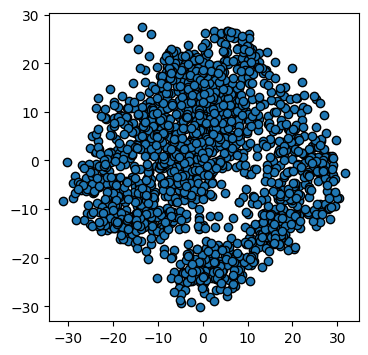

In [7]:
# We are passing None becuase it is an unlabelled plot
plots_labels(x_pca, None)

We now have a 2D representation of our 64D dataset that we can work with instead. Let's try some quick K-means clustering on our 2D representation of the data. Because we already have some knowledge about our data we can set `k=10` for the 10 digits present in the dataset.

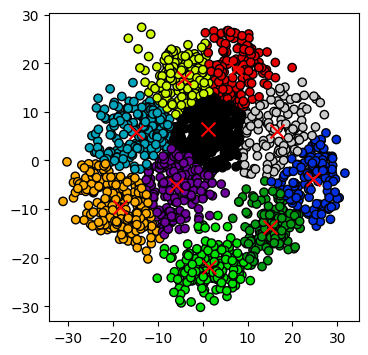

In [8]:
import sklearn.cluster as skl_cluster
Kmean = skl_cluster.KMeans(n_clusters=10)
Kmean.fit(x_pca)
clusters = Kmean.predict(x_pca)
plot_clusters(x_pca, clusters, Kmean)

And now we can compare how these clusters look against our actual image labels by colour coding our first scatter plot:

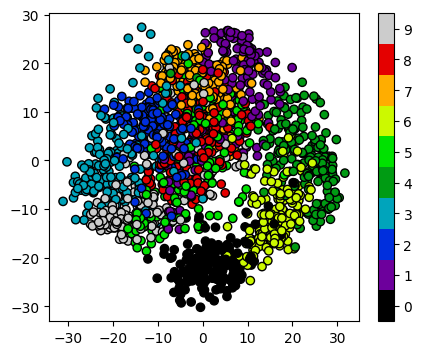

In [9]:
plot_clusters_labels(x_pca, labels)

PCA has done a valiant effort to reduce the dimensionality of our problem from 64D to 2D while still retaining some of our key structural information. We can see that the digits `0`,`1`,`4`, and `6` cluster up reasonably well even using a simple k-means test. However it does look like there is still quite a bit of overlap between the remaining digits, especially for the digits `5` and `8`. The clustering is from perfect in the largest "blob", but not a bad effort from PCA given the substantial dimensionality reduction.

It's worth noting that PCA does not handle outlier data well primarily due to global preservation of structural information, and so we will now look at a more complex form of learning that we can apply to this problem.

### t-distributed Stochastic Neighbor Embedding (t-SNE)
t-SNE is a powerful example of manifold learning - a non-deterministic non-linear approach to dimensionality reduction. A **manifold** is a way to think about complex, high-dimensional data as if it exists on a simpler, lower-dimensional shape within that space. Imagine a crumpled piece of paper: while it exists in 3D space when crumpled, the surface of the paper itself is inherently 2D. Similarly, in many datasets, the meaningful patterns and relationships lie along such "lower-dimensional surfaces" within the high-dimensional space. For example, in image data like MNIST, the raw pixels (hundreds of dimensions) may seem high-dimensional, but the actual structure (the shapes of digits) is much simpler, often following a lower-dimensional manifold. Manifold learning techniques like t-SNE aim to "uncrumple" the data and flatten it into a lower-dimensional space, while preserving the relationships between points as much as possible.

### Intuition for t-SNE
t-SNE (**t-distributed Stochastic Neighbor Embedding**) is a method for visualizing high-dimensional data by mapping it into a low-dimensional space, typically 2D or 3D, while emphasizing *local relationships*. It focuses on keeping nearby points close together, helping to reveal clusters or patterns that may be hidden in the original high-dimensional space.

**An analogy**: Imagine moving a group of friends from a large, crowded park into a much smaller garden while trying to keep people who are chatting with each other close. You won’t care much about preserving the exact distances between groups from the original park—your main goal is to keep friends near each other in the smaller space. Similarly, t-SNE prioritizes preserving these *local connections*, while global distances between clusters may be distorted or not reflect their true relationships. This distortion happens because t-SNE sacrifices global structure to accurately capture local neighborhoods. For example:
- Two clusters that appear far apart in the t-SNE plot may actually be closer in the original high-dimensional space.
- Similarly, clusters that appear close together in the plot might not actually be neighbors in the original space.

As a result, while t-SNE is excellent for discovering *local patterns* (e.g., clusters, subgroups), you should be cautious about interpreting the relative distances between clusters. These are less reliable and are influenced by how the algorithm optimizes its layout in the reduced space. It's best to use t-SNE as a tool to find grouping and then validate these findings using additional analysis.

For more in depth explanations of t-SNE and manifold learning please see the following links which also contain som very nice visual examples of manifold learning in action:
* [https://thedatafrog.com/en/articles/visualizing-datasets/](https://thedatafrog.com/en/articles/visualizing-datasets/)
* [https://scikit-learn.org/stable/modules/manifold.html](https://scikit-learn.org/stable/modules/manifold.html)

Scikit-Learn allows us to apply t-SNE in a relatively simple way. Lets code and apply t-SNE to the MNIST dataset in the same manner that we did for the PCA example, and reduce the data down from 64D to 2D again:

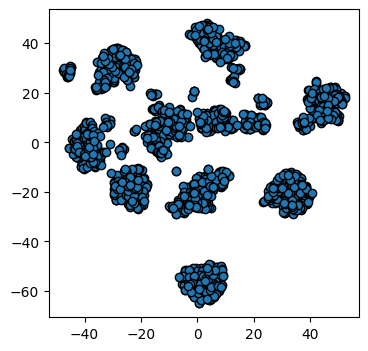

In [10]:
# t-SNE embedding
from sklearn import manifold

# initialising with "pca" explicitly preserves global structure
tsne = manifold.TSNE(n_components=2, init='pca', random_state = 0)
x_tsne = tsne.fit_transform(features)

plots_labels(x_tsne, None)

It looks like t-SNE has done a much better job of splitting our data up into clusters using only a 2D representation of the data. Once again, let's run a simple k-means clustering on this new 2D representation, and compare with the actual color-labelled data:

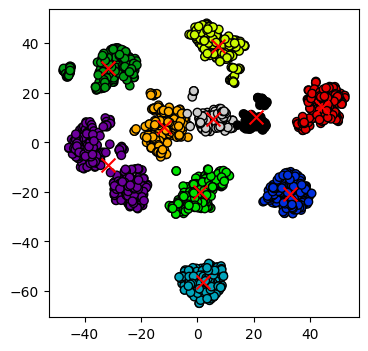

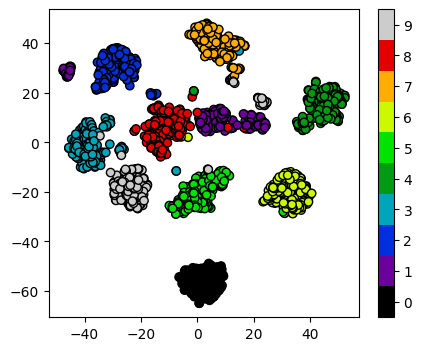

In [11]:
Kmean = skl_cluster.KMeans(n_clusters=10)

Kmean.fit(x_tsne)
clusters = Kmean.predict(x_tsne)

plot_clusters(x_tsne, clusters, Kmean)
plot_clusters_labels(x_tsne, labels)

It looks like t-SNE has successfully separated out our digits into accurate clusters using as little as a 2D representation and a simple k-means clustering algorithm. It has worked so well that you can clearly see several clusters which can be modelled, whereas for our PCA representation we needed to rely heavily on the knowledge that we had 10 types of digits to cluster.

Additionally, if we had run k-means on all 64 dimensions this would likely still be computing away, whereas we have already broken down our dataset into accurate clusters, with only a handful of outliers and potential misidentifications (remember, a good ML model isn't a perfect model!)

The major drawback of applying t-SNE to datasets is the large computational requirement. Furthermore, hyper-parameter tuning of t-SNE usually requires some trial and error to perfect. 

Our example here is still a relatively simple example of 8x8 images and not very typical of the modern problems that can now be solved in the field of ML and DL. To account for even higher-order input data, neural networks were developed to more accurately extract feature information.


::::::::::::::::::::::::::::::::::::: challenge


## Exercise: Working in three dimensions
The above example has considered only two dimensions since humans
can visualize two dimensions very well. However, there can be cases
where a dataset requires more than two dimensions to be appropriately
decomposed. Modify the above programs to use three dimensions and 
create appropriate plots.
Do three dimensions allow one to better distinguish between the digits?

## Solution

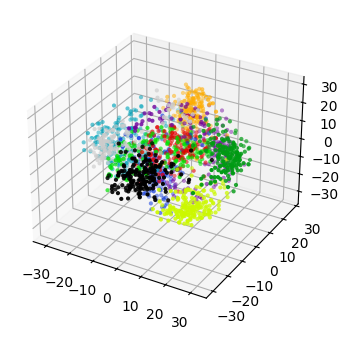

In [12]:
from mpl_toolkits.mplot3d import Axes3D
# PCA
pca = decomposition.PCA(n_components=3)
pca.fit(features)
x_pca = pca.transform(features)
fig = plt.figure(1, figsize=(4, 4))
ax = fig.add_subplot(projection='3d')
ax.scatter(x_pca[:, 0], x_pca[:, 1], x_pca[:, 2], c=labels,
          cmap=plt.cm.nipy_spectral, s=9, lw=0)
plt.show()

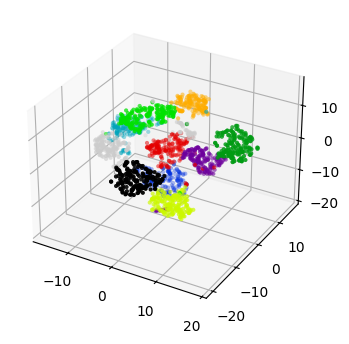

In [13]:
# t-SNE embedding
tsne = manifold.TSNE(n_components=3, init='pca',
        random_state = 0)
x_tsne = tsne.fit_transform(features)
fig = plt.figure(1, figsize=(4, 4))
ax = fig.add_subplot(projection='3d')
ax.scatter(x_tsne[:, 0], x_tsne[:, 1], x_tsne[:, 2], c=labels,
          cmap=plt.cm.nipy_spectral, s=9, lw=0)
plt.show()

::::::::::::::::::::::::::::::::::::::::::::::::

::::::::::::::::::::::::::::::::::::: challenge


## Exercise: Parameters

Look up parameters that can be changed in PCA and t-SNE,
and experiment with these. How do they change your resulting
plots?  Might the choice of parameters lead you to make different
conclusions about your data?

::::::::::::::::::::::::::::::::::::::::::::::::

::::::::::::::::::::::::::::::::::::: challenge


## Exercise: Other algorithms

There are other algorithms that can be used for doing dimensionality
reduction (for example the Higher Order Singular Value Decomposition (HOSVD)).
Do an internet search for some of these and
examine the example data that they are used on. Are there cases where they do 
poorly? What level of care might you need to use before applying such methods
for automation in critical scenarios?  What about for interactive data 
exploration?

::::::::::::::::::::::::::::::::::::::::::::::::

{% include links.md %}

::::::::::::::::::::::::::::::::::::: keypoints 

- PCA is a linear dimensionality reduction technique for tabular data
- t-SNE is another dimensionality reduction technique for tabular data that is more general than PCA

::::::::::::::::::::::::::::::::::::::::::::::::